In [1]:
# Third-party
from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from matplotlib import cm

from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp
from scipy.optimize import minimize

# Density model class:

In [2]:
from density import get_projected_coords, get_u_v, get_uniform_idx

In [743]:
class DensityModel2D:

    def __init__(self, X, poly_deg=5):
        """TODO:

        Parameters
        ----------

        """
            
        # Projected coordinates
        self.X = X # (N, D)
        self.N, self.D = self.X.shape
        
        if self.D != 2:
            raise NotImplementedError('D={0}'.format(D))

        # Fit a polynomial to the projected coordinates
        self.poly = np.poly1d(np.polyfit(X[:, 0], X[:, 1], deg=poly_deg))

        self.nodes = None
        self.K = None

    def get_dense_poly_track(self, size=None, xgrid=None):
        if ((xgrid is None and size is None) or
                (xgrid is not None and size is not None)):
            raise ValueError('You must either pass in a `size` for the poly '
                             'grid, or pass in `xgrid`.')

        if xgrid is None:
            xgrid = np.linspace(X[:, 0].min(), X[:, 0].max(), size)

        track = np.stack((xgrid, self.poly(xgrid))).T
        return track # (many, D)

    def set_nodes(self, track, nodes=None, spacing=None):
        if nodes is not None and spacing is not None:
            raise ValueError('Set either spacing or nodes, not both!')
            
        if nodes is not None:
            self.nodes = np.array(nodes)
            self.K = len(self.nodes)
            
            idx = []
            for k in range(self.K):
                i = np.linalg.norm(track - self.nodes[k][None], axis=1).argmin()
                idx.append(i)
            idx = np.array(idx)
        
        else:
            idx = get_uniform_idx(track[:, 0], track[:, 1], 
                                  spacing=spacing)
            self.nodes = track[idx]
            self.K = len(idx)

        # cache the u_k's at each node
        self._u_k = np.zeros((self.K, self.D))
        self._R_k = np.zeros((self.K, self.D, self.D))
        for k, j in enumerate(idx):
            self._u_k[k] = get_u_v(j, track[:, 0], track[:, 1],
                                   self.poly, eps=1e-3)[0] # HACK: eps?
            self._R_k[k] = self._get_R(self._u_k[k])

        return self.nodes

    def _get_R(self, u_vec):
        # TODO: only works for 2D
        theta = np.arctan2(u_vec[1], u_vec[0])

        # rotation from u,v to x,y (sky-tangent-plane, area conserved)
        R = np.zeros([2, 2])
        R[0, 0] = R[1, 1] = np.cos(theta)
        R[0, 1] = -np.sin(theta)
        R[1, 0] = np.sin(theta)

        return R

    def get_Ck(self, k, s_k, h):
        """Get the 2D covariance matrix in x-y coordinates at the node k.

        Parameters
        ----------
        u_k : array_like

        Given tangent normalized vector at a given node k,
        this function takes the "bandwidth", h, and the function, s_k,
        and returns the covarience matrix"""

        # 2x2 covariance matrix in the u-v plane
        Ck_prim = np.zeros([2, 2])
        Ck_prim[0, 0] = h ** 2
        Ck_prim[1, 1] = s_k ** 2

        # retrieve pre-computed matrix
        R = self._R_k[k]

        # rotate the covariance matrix to the x-y space
        Ck = R @ Ck_prim @ R.T
        return Ck

    def ln_density(self, X, a_k, s_k, h):
        ln_dens = np.zeros((self.K, len(X)))
        for k in range(self.K):
            C = self.get_Ck(k, s_k[k], h)
            try:
                ln_dens[k] = mvn.logpdf(X, self.nodes[k], C,
                                        allow_singular=True)
            except ValueError as e:
                raise e
        return logsumexp(ln_dens + np.log(a_k)[:, None], axis=0)

## Make fake data where we know the answer:

In [739]:
from sklearn.mixture import GaussianMixture

In [740]:
D = 2
h = 1.

In [772]:
rnd = np.random.RandomState(22)
true_K = 10
true_nodes = np.stack((np.linspace(0, 10, true_K),
                       np.zeros(true_K))).T
true_s = rnd.uniform(0.5, 1., size=true_K)

true_z = rnd.uniform(0.8, 0.95, size=true_K-1)
true_a = z_to_a(true_z)
assert np.isclose(true_a.sum(), 1.)

true_dens_model = DensityModel2D(X)
true_dens_model.poly = np.poly1d([0.])
track = true_dens_model.get_dense_poly_track(size=10000)
nodes = true_dens_model.set_nodes(track=track, nodes=true_nodes)

In [773]:
dens_model = DensityModel2D(X)
track = dens_model.get_dense_poly_track(size=10000)
nodes = dens_model.set_nodes(spacing=0.5, track=track)

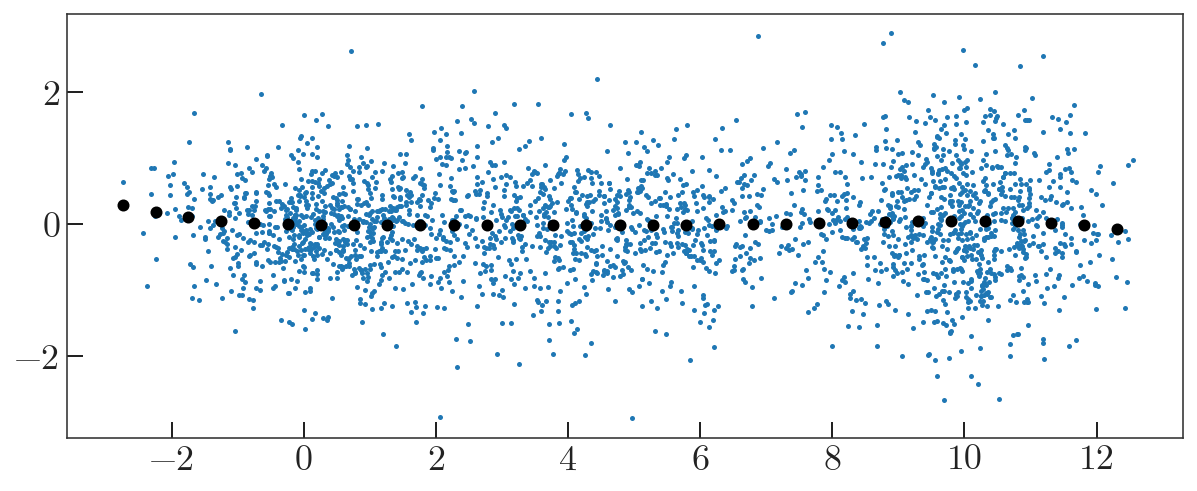

In [774]:
plt.figure(figsize=(10, 4))
plt.plot(X[:, 0], X[:, 1], marker='.', ls='none')
plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='k')
plt.gca().set_aspect('equal')

## Probabilistic model class

A lesson in over-engineering

In [775]:
K = dens_model.K

In [776]:
# ak0 = np.ones(dens_model.K) / dens_model.K
# assert np.isclose(np.sum(ak0), 1.)
# ln_ak0 = np.log(ak0)

sk0 = 0.5 * np.ones(dens_model.K)
# sk0 = true_s

In [777]:
# z0 = np.ones(K-1)
# z0 = true_z

z0 = a_to_z(np.ones(K)/K)

In [778]:
def z_to_a(zj):
    K = len(zj) + 1
    a = np.zeros(K)
    a[0] = 1 - zj[0]
    for k in range(1, K-1):
        a[k] = np.prod(zj[:k]) * (1 - zj[k])
    a[K-1] = np.prod(zj)
    return a


def a_to_z(ak):
    K = len(ak)
    z = np.zeros(K - 1)
    z[0] = 1 - ak[0]
    for i in range(1, K-1):
        z[i] = 1 - ak[i] / np.prod(z[:i])
    return z


class Model:

    def __init__(self, density_model, h, frozen=None):
        if frozen is None:
            frozen = dict()
        self.frozen = dict(frozen)
        
        if density_model.K is None:
            raise ValueError('Density model not initialized')
        self.density_model = density_model
        self._X = density_model.X
        self._K = self.density_model.K
        
        self.h = h
        
        self._params = dict()
        self._params['ln_z'] = (self.density_model.K-1, )
        self._params['ln_s'] = (self.density_model.K, )

    def pack_pars(self, **kwargs):
        vals = []
        for k in sorted(list(self._params.keys())):
            frozen_val = self.frozen.get(k, None)
            val = kwargs.get(k, frozen_val)
            if val is None:
                raise ValueError("No value passed in for parameter {0}, but "
                                 "it isn't frozen either!".format(k))
            vals.append(val)
        return np.concatenate(vals)

    def unpack_pars(self, p):
        key_vals = []
        
        j = 0
        for name in sorted(list(self._params.keys())):
            shape = self._params[name]
            size = np.prod(shape)
            if name in self.frozen:
                key_vals.append((name, self.frozen[name]))
            else:
                key_vals.append((name, p[j:j+size]))
                j += size

        return dict(key_vals)
    
    def get_a(self, p):
        zj = np.exp(p['ln_z'])
        return z_to_a(zj)
        # return z_to_a(p['z'])
    
    def get_s(self, p):
        s = np.exp(p['ln_s'])
        return s
        # return p['s']

    # =========================================================================
    # Probability functions:
    #

    def ln_prior(self, p):
        lp = 0.

        # if 'ln_a' not in self.frozen:
        #     if np.any(p['ln_a'] < -8) or np.any(p['ln_a'] > 0):
        #         return -np.inf
            
        # if 'ln_s' not in self.frozen:
        #     if np.any(p['ln_s'] < -5) or np.any(p['ln_s'] > 2.5):
        #         return -np.inf
        # if np.any(p['s'] < 0):
        #     return -np.inf
        
        # if np.any(p['z'] < 0) or np.any(p['z'] > 1):
        #     return -np.inf
        
        if np.any(p['ln_z'] > 0):
            return -np.inf

        return lp

    def ln_likelihood(self, p):
        s = self.get_s(p)
        a = self.get_a(p)
        return self.density_model.ln_density(self._X, a, s, self.h)

    def ln_posterior(self, p):
        # unpack parameter vector, p
        kw_pars = self.unpack_pars(p)

        lnp = self.ln_prior(kw_pars)
        if not np.isfinite(lnp):
            return -np.inf

        lnl = self.ln_likelihood(kw_pars)
        if not np.isfinite(lnl).all():
            return -np.inf

        return lnp + lnl.sum()

    def __call__(self, p):
        return self.ln_posterior(p)

In [779]:
model = Model(dens_model, h=h)

### Compute numerical derivatives

In [686]:
eps = 1e-7

num_derivs_s = []
for k in range(K):
    s1 = sk0.copy()
    s2 = s1.copy()
    s2[k] = s2[k] + eps
    _d = (model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': np.log(s2)}).sum() -
          model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': np.log(s1)}).sum()) / eps
    num_derivs_s.append(_d)
num_derivs_s = np.array(num_derivs_s)
num_derivs_s

array([ 421.20536818,  427.91016313,  368.28001612,  329.91019907,
        282.34802812,  202.28359062,  184.51504729,  364.86482713,
        965.32354291, 2113.18754737])

In [687]:
eps = 1e-6

num_derivs_z = []
for k in range(K - 1):
    z1 = z0.copy()
    z2 = z1.copy()
    z2[k] = z2[k] + eps

    _d = (model.ln_likelihood({'ln_z': np.log(z2), 'ln_s': np.log(sk0)}).sum() -
          model.ln_likelihood({'ln_z': np.log(z1), 'ln_s': np.log(sk0)}).sum()) / eps
    num_derivs_z.append(_d)
num_derivs_z = np.array(num_derivs_z)
num_derivs_z

array([-1219.0711459 ,  -460.83819871,   149.47959971,   378.6416255 ,
         337.41358129,   414.99792496,   676.36162203,   726.81784513,
         443.55858336])

In [627]:
def derivs(density_model, z, s, h):
    nodes = density_model.nodes
    R = density_model._R_k
    K = density_model.K
    X = density_model.X
    (N, D) = X.shape
    
    a = z_to_a(z)
    
    # We need this for all of the derivatives
    ln_N_nk = np.zeros((N, K))
    C = np.zeros((K, D, D))
    for k in range(K):
        C[k] = density_model.get_Ck(k, s[k], h)
        ln_N_nk[:, k] = mvn.logpdf(X, nodes[k], C[k], 
                                   allow_singular=True)
    ln_aN_nk = np.log(a) + ln_N_nk
    ln_denom = logsumexp(ln_aN_nk, axis=1)
    
    # ---
    ln_last_K = ln_N_nk[:, -1]
    ln_d_lnL_d_a = logsumexp(ln_N_nk - ln_denom[:, None], axis=0)
    d_lnL_d_a = np.exp(ln_d_lnL_d_a)
    
    d_lnL_d_z = np.zeros(K-1)
    for k in range(K-1):
        term1 = a[k] / (z[k] - 1) * d_lnL_d_a[k]
        
        term2 = 0.
        for j in range(k+1, K):
            term2 += a[j] / z[k] * d_lnL_d_a[j]
        d_lnL_d_z[k] = term1 + term2
    
    # ---
    
    ln_d_lnL_d_sk = np.zeros((N, K))
    ln_s = np.log(s)
    signs = np.zeros((N, K))
    for k in range(K):
        b = X - nodes[k:k+1]
        
        # what APW derived:
        term = ((b[:, 1]*R[k,0,0] + b[:, 0]*R[k,0,1])**2/s[k]**2 - 1) / s[k]
        
        signs[:, k] = np.sign(term)
        log_term = np.log(np.abs(term))
        
        ln_d_lnL_d_sk[:, k] = ln_aN_nk[:, k] + log_term - ln_denom
    
    ln_d_lnL_d_s, sign = logsumexp(ln_d_lnL_d_sk, b=signs, axis=0, return_sign=True)
    d_lnL_d_s = sign * np.exp(ln_d_lnL_d_s)
    return d_lnL_d_z, d_lnL_d_s

In [756]:
exact_derivs_z, exact_derivs_s = derivs(dens_model, z0, sk0, h)

In [629]:
print(exact_derivs_z)
print(num_derivs_z)

[ 78.7152198  -30.27765601 -54.2371941   84.16694473   8.2000773
 -18.29256552  41.27564281 114.21996118  43.93513054]
[ 78.71023809 -30.28088577 -54.24020856  84.16445598   8.19813795
 -18.29439134  41.27419379 114.21895033  43.93471681]


In [630]:
print(exact_derivs_s)
print(num_derivs_s)

[-17.28332408 -18.66501396 -20.92708056 -27.12154454 -18.23866657
 -47.41286893 -15.33164604  -6.27838889 -10.39427063 -50.76231147]
[-17.28338248 -18.66501407 -20.92707291 -27.12156856 -18.23867933
 -47.41290468 -15.33164323  -6.27838745 -10.39428753 -50.76239177]


### Compare log derivatives e.g., d/d(lns)

In [631]:
exact_derivs_lnz = exact_derivs_z * z0
exact_derivs_lns = exact_derivs_s * sk0

In [632]:
eps = 1e-8

num_derivs_lnz = []
for k in range(dens_model.K-1):
    ln_z1 = np.log(z0)
    ln_z2 = ln_z1.copy()
    ln_z2[k] = ln_z2[k] + eps

    _d = (model.ln_likelihood({'ln_z': ln_z2, 'ln_s': np.log(sk0)}).sum() -
          model.ln_likelihood({'ln_z': ln_z1, 'ln_s': np.log(sk0)}).sum()) / eps
    num_derivs_lnz.append(_d)
num_derivs_lnz = np.array(num_derivs_lnz)

In [633]:
eps = 1e-8

num_derivs_lns = []
for k in range(dens_model.K):
    ln_s1 = np.log(sk0)
    ln_s2 = ln_s1.copy()
    ln_s2[k] = ln_s2[k] + eps

    _d = (model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': ln_s2}).sum() -
          model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': ln_s1}).sum()) / eps
    num_derivs_lns.append(_d)
num_derivs_lns = np.array(num_derivs_lns)

In [634]:
print(num_derivs_lnz)
print(exact_derivs_lnz)

[ 63.09637683 -26.77115845 -50.00983947  76.74025255   6.79247023
 -14.65086825  37.8004188  107.78639989  39.7740223 ]
[ 63.09646963 -26.77091468 -50.00988905  76.7404781    6.792671
 -14.65090225  37.80050531 107.78650191  39.77406431]


In [635]:
print(num_derivs_lns)
print(exact_derivs_lns)

[-10.44318196 -13.82759365 -14.86405381 -25.21192073 -10.68037818
 -31.7399099   -9.73959686  -5.30853868  -6.34263415 -45.98932719]
[-10.44310755 -13.82779885 -14.86385695 -25.21194369 -10.68021254
 -31.73969074  -9.73967984  -5.30850762  -6.34260741 -45.9894085 ]


### Visualize likelihood vs. parameters

In [637]:
# for k in range(dens_model.K):
#     _deriv = []
#     vals = np.linspace(0.5, 1, 128)
#     for val in vals:
#         ss = sk0.copy()
#         ss[k] = val
#         _, exact_derivs_s = derivs(dens_model, z0, ss, h)
#         _deriv.append(exact_derivs_s[k])
        
#     ls, = plt.plot(vals, _deriv)
#     plt.axhline(0)
#     plt.axvline(true_s[k], color=ls.get_color())
#     plt.yscale('symlog')

In [638]:
# for k in range(dens_model.K-1):
#     _deriv = []
#     vals = np.linspace(1e-2, 1-1e-2, 128)
#     for val in vals:
#         zz = z0.copy()
#         zz[k] = val
#         exact_derivs_z, _ = derivs(dens_model, zz, sk0, h)
#         _deriv.append(exact_derivs_z[k])
        
#     ls, = plt.plot(vals, _deriv)
#     plt.axhline(0)
#     plt.axvline(true_z[k], color=ls.get_color())
#     plt.yscale('symlog')

---

## Optimize:

In [759]:
p0 = {'ln_s': np.log(sk0),
      'ln_z': np.log(z0)}
x0 = model.pack_pars(**p0)

model.ln_posterior(x0)

-10356.687909059798

In [760]:
def likelihood_helper(x):
    # print(x.tolist())
    return -model.ln_posterior(x)

def deriv_helper(x):
    p = model.unpack_pars(x)
    z = np.exp(p['ln_z'])
    a = model.get_a(p)
    s = model.get_s(p)
    d_dz, d_ds = derivs(model.density_model, z, s, h)
    return -np.concatenate((d_ds * s, d_dz * z)) # d/dlnz, d/dlns
#     return -np.concatenate((d_dz, d_ds)) # d/dlnz, d/dlns

In [728]:
def num_deriv_helper(x):
    wps = 1e-8
    num_derivs = []
    for k in range(x0.size):
        x1 = x.copy()
        x2 = x1.copy()
        x2[k] = x2[k] + eps
        _d = (likelihood_helper(x2) - likelihood_helper(x1)) / eps
        num_derivs.append(_d)
    return np.array(num_derivs)

In [729]:
eps = 1e-8

num_derivs = []
for k in range(x0.size):
    x1 = true_x.copy()
    x2 = x1.copy()
    x2[k] = x2[k] + eps
    _d = (likelihood_helper(x2) - likelihood_helper(x1)) / eps
    num_derivs.append(_d)
num_derivs = np.array(num_derivs)
num_derivs

array([ -304.20796975,  -222.38054953,  -176.10764189,  -154.71487131,
        -118.54535842,   -87.70457498,  -114.49556041,  -233.75432647,
        -412.78835852, -1005.21447166, -1529.37009261, -1456.54121297,
       -1335.6186173 , -1153.96469482,  -953.89696071,  -828.9471225 ,
        -736.662696  ,  -537.76857385,  -241.08667276])

In [761]:
# res = minimize(likelihood_helper, jac=num_deriv_helper, 
#                x0=x0, method='L-BFGS-B')

bounds = [[-8, 4]]*K + [[-8, -1e-9]]*(K-1)

res = minimize(likelihood_helper, jac=deriv_helper, 
               x0=x0, method='L-BFGS-B', 
               bounds=bounds,
               options=dict(ftol=1e-13))

# res = minimize(likelihood_helper, x0=x0, 
#                method='powell')
res

      fun: 9298.439298247315
 hess_inv: <61x61 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.57533439e-07,  2.56651313e-07,  1.77579201e-07,  6.98492697e-08,
        1.68693283e-08,  7.07566246e-04,  2.44053629e-04,  3.53633616e-04,
       -1.22434785e-08, -7.11885311e-09, -5.01240115e-04,  2.29548683e-07,
        4.16393623e-04,  7.39345796e-04,  3.28735464e-08,  2.44714378e-07,
       -1.58274384e-04, -9.67049836e-04,  4.57326872e-04,  1.73374794e-08,
        1.46863878e-09,  3.86219567e-05,  7.78906540e-09,  4.06724272e-08,
       -7.54660240e-09,  9.78155070e-04,  1.47332898e-04, -6.97080216e-04,
        1.22584080e-05,  1.01500301e-05,  3.84197495e-06, -1.06228623e+03,
       -5.79044594e+02, -2.41868021e+02, -6.83129433e+01, -1.08326952e+01,
        1.23092380e-03, -1.47623975e-04, -2.10805033e-03, -3.10700248e+00,
       -1.47459672e+00,  2.11445020e-04, -4.18953881e+01,  1.73552335e-05,
        5.32359897e-04, -7.98938607e+00, -5.33442407e+01,  5.23020771e-05,
  

Text(0.5,1,'fit with gradients')

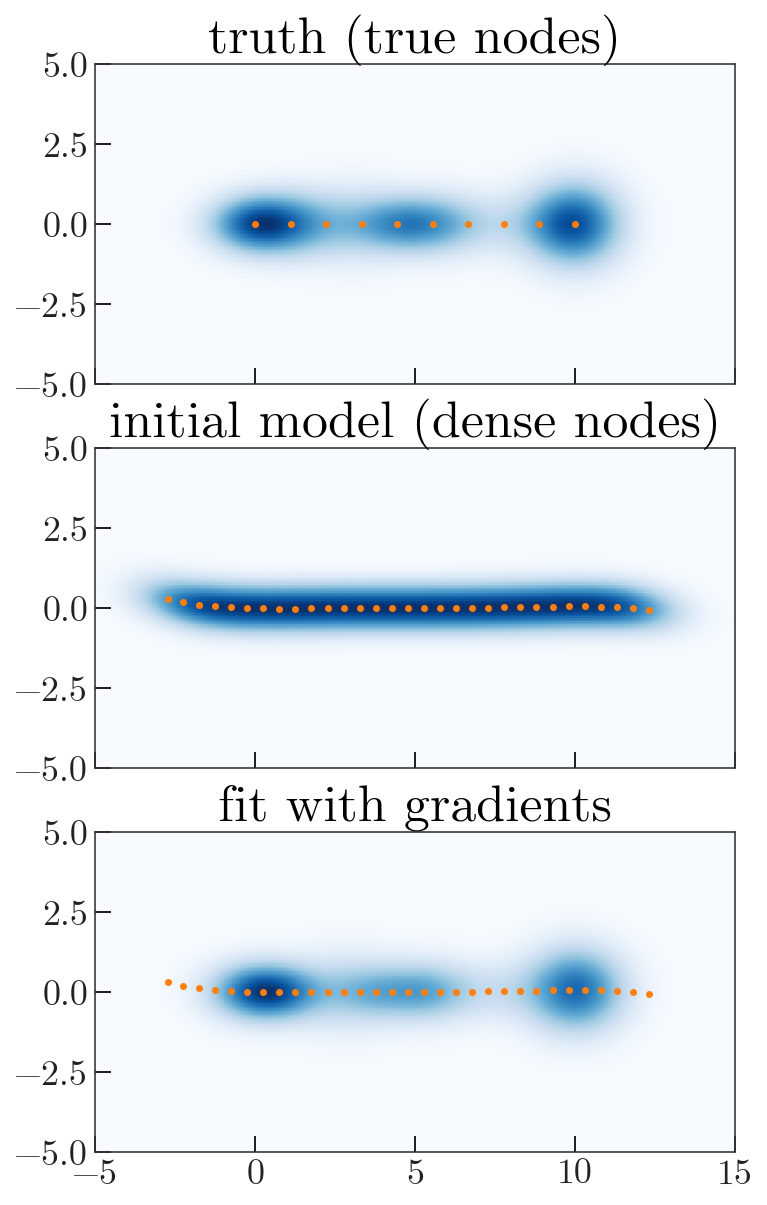

In [789]:
bins = (np.arange(-10, 15+1e-3, 0.05),
        np.arange(-5, 5+1e-3, 0.05))
x, y = np.meshgrid(*bins)
xy = np.stack((x.ravel(), y.ravel())).T

fig, axes = plt.subplots(3, 1, figsize=(10, 10), 
                         sharex=True, sharey=True)

ax = axes[0]
ln_dens = true_dens_model.ln_density(xy, true_a, true_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(true_nodes[:, 0], true_nodes[:, 1],
           marker='.', color='tab:orange')

ax = axes[1]
med_p = model.unpack_pars(x0)
med_a = model.get_a(med_p)
med_s = model.get_s(med_p)
ln_dens = dens_model.ln_density(xy, med_a, med_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(dens_model.nodes[:, 0], dens_model.nodes[:, 1],
           marker='.', color='tab:orange')

ax = axes[2]
med_p = model.unpack_pars(res.x)
med_a = model.get_a(med_p)
med_s = model.get_s(med_p)
ln_dens = dens_model.ln_density(xy, med_a, med_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(dens_model.nodes[:, 0], dens_model.nodes[:, 1],
           marker='.', color='tab:orange')

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(-5, 15)

axes[0].set_title('truth (true nodes)')
axes[1].set_title('initial model (dense nodes)')
axes[2].set_title('fit with gradients')

---

## Sample

In [281]:
import emcee

In [286]:
true_x = np.concatenate((np.log(true_s), np.log(true_z)))
x0 = true_x

In [287]:
sampler = emcee.EnsembleSampler(nwalkers=64, ndim=x0.size, 
                                log_prob_fn=model.ln_posterior)

In [288]:
x0s = emcee.utils.sample_ball(true_x, [1e-7]*x0.size, size=64)

In [289]:
_ = sampler.run_mcmc(x0s, nsteps=256, progress=True)

100%|██████████| 256/256 [00:25<00:00, 10.18it/s]


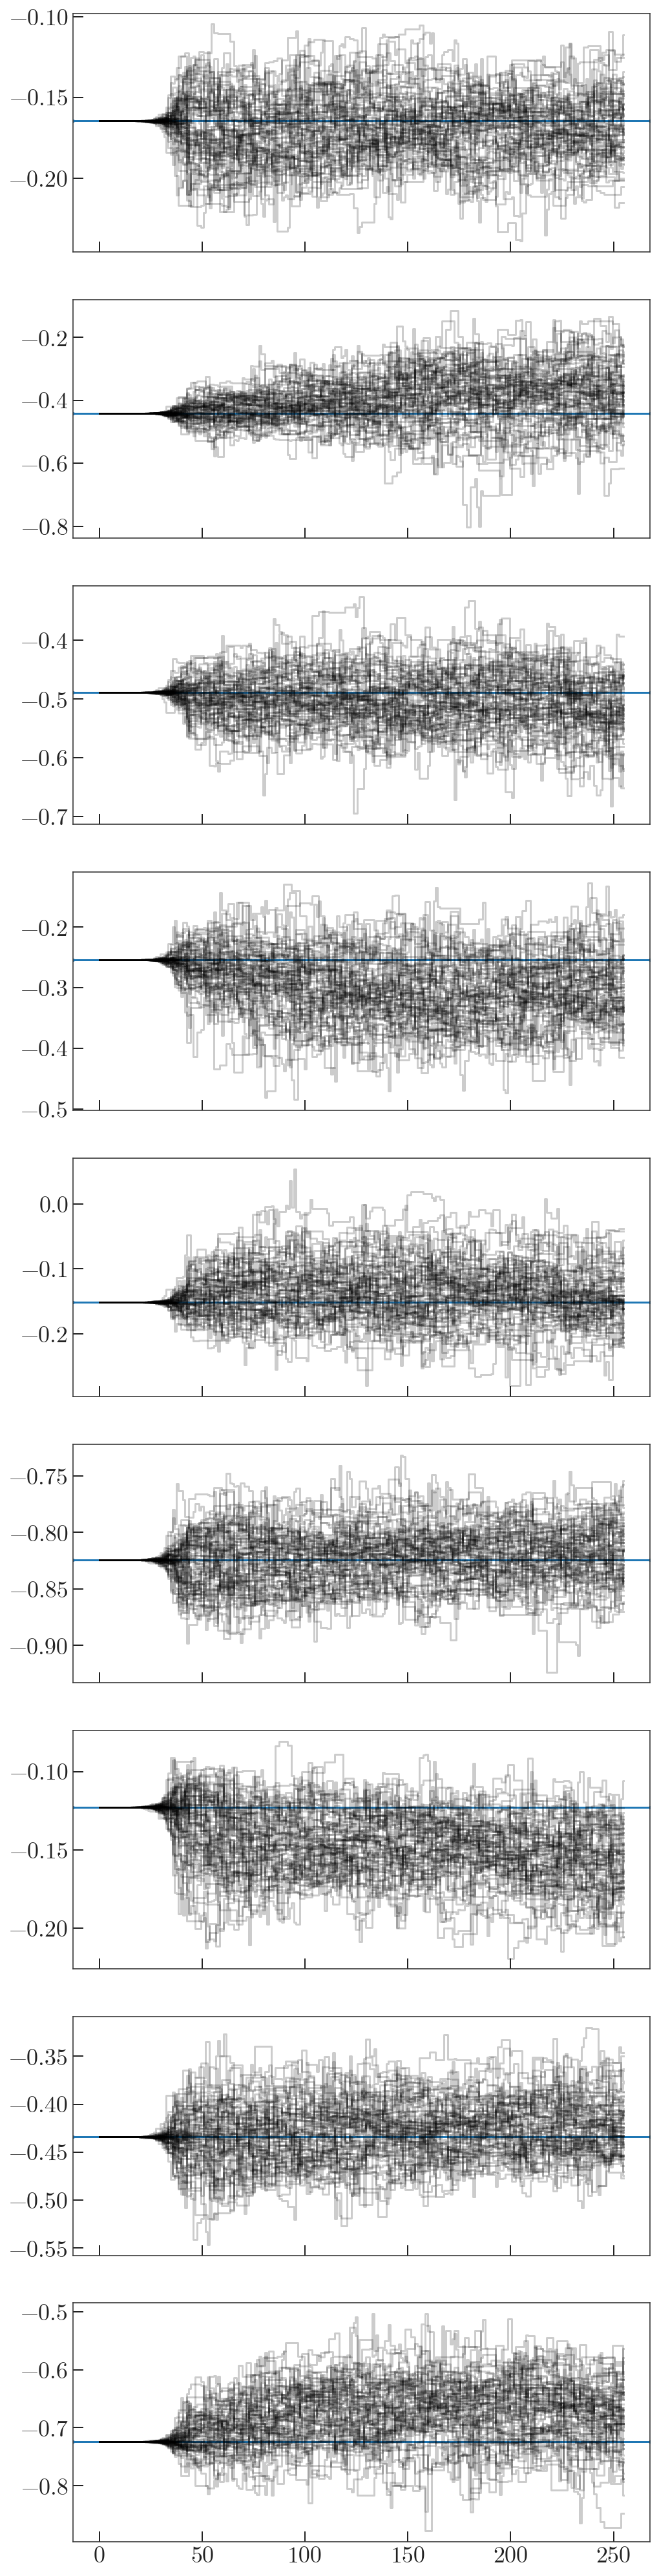

In [290]:
fig, axes = plt.subplots(x0.size, 1, figsize=(8, 4*x0.size), 
                         sharex=True)
for k in range(sampler.chain.shape[-1]):
    ax = axes[k]
    for walker in sampler.chain[..., k]:
        ax.plot(walker, marker='', drawstyle='steps-mid', color='k', alpha=0.2)
    ax.axhline(true_x[k], zorder=-10, color='tab:blue')

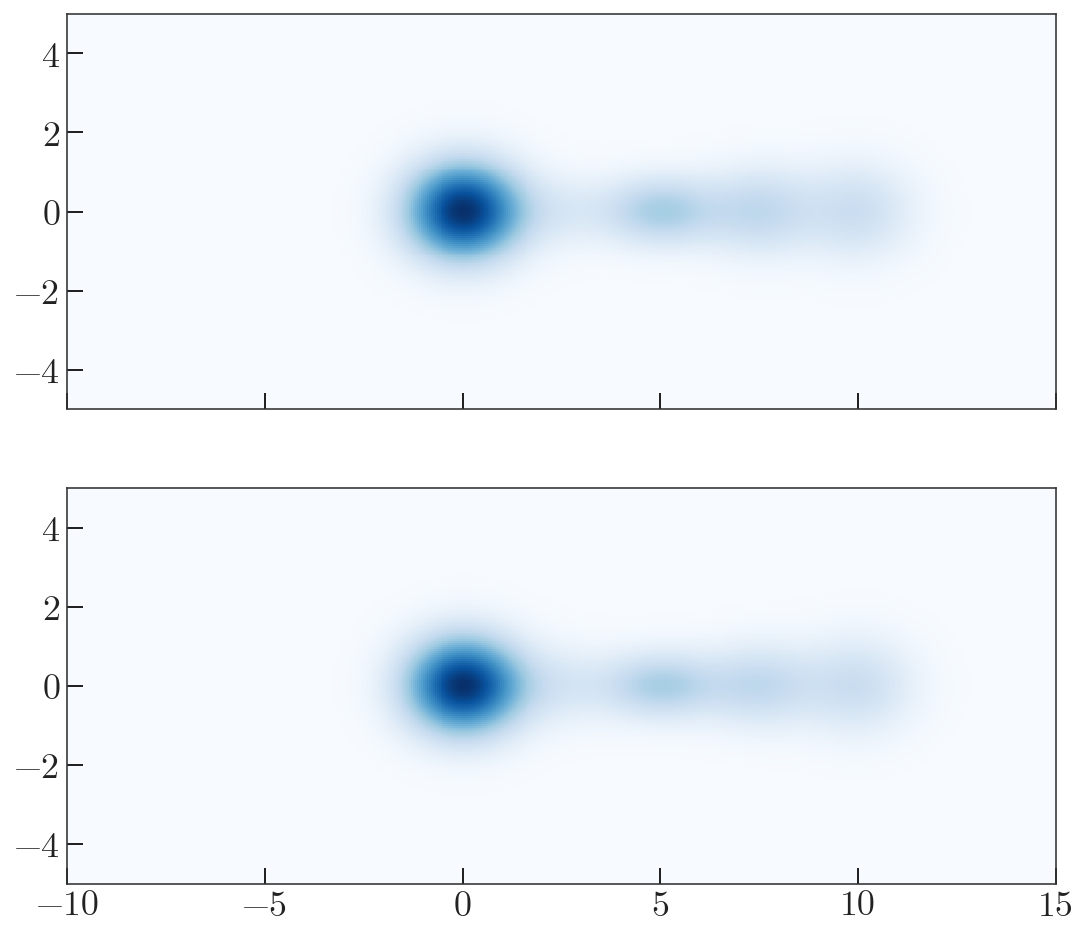

In [291]:
bins = (np.arange(-10, 15+1e-3, 0.05),
        np.arange(-5, 5+1e-3, 0.05))
x, y = np.meshgrid(*bins)
xy = np.stack((x.ravel(), y.ravel())).T

fig, axes = plt.subplots(2, 1, figsize=(10, 8), 
                         sharex=True, sharey=True)

ax = axes[0]
ln_dens = dens_model.ln_density(xy, true_a, true_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')

ax = axes[1]
med_p = model.unpack_pars(np.median(sampler.chain[:, -1], axis=0))
med_a = model.get_a(med_p)
med_s = model.get_s(med_p)
ln_dens = dens_model.ln_density(xy, med_a, med_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')

for ax in axes:
    ax.set_aspect('equal')